In [ ]:
#algorithms needed: upscaling methods, ksvdbox, ompbox

In [1]:
import time
import scipy
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import math
from sklearn.linear_model import Lasso
from sklearn.decomposition import SparseCoder

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Yi Ma implementation

In [2]:
patch_size = 3 #patch size for the low resolution input image
overlap = 2; #overlap between adjacent patches (for low res)
#lambda = 0.1; % sparsity parameter
zooming = 3

In [3]:
def calculate_psnr(img1, img2):
    # img1 and img2 have range [0, 255]
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))



def show_image(img):
    
    img = np.clip(img,a_min=0,a_max=255)
    print(np.max(img))
    
    fig = plt.figure(figsize=(5,5))
    ax1 = fig.add_subplot(111)

    if len(img.shape)==3 and img.shape[2]==3:
        imgplot = ax1.imshow(img)
    elif len(img.shape)==2:
        imgplot = ax1.imshow(img,cmap='gray')

    plt.show()

In [4]:
yima_dict = scipy.io.loadmat('CVPR08-SR/Data/Dictionary/Dictionary.mat')
dict_hires = yima_dict['Dh']
dict_lores = yima_dict['Dl']


In [5]:
yima_weights_baby = scipy.io.loadmat(
    '/scratch_net/kringel/hchoong/github/quantum-cv/AplusCodes_SR/yima_weights_baby.mat')

matlab_Ws = yima_weights_baby['all_ws'] #order: goes down column first (vertical)
matlab_means = yima_weights_baby['all_mmeans']
matlab_norms = yima_weights_baby['all_mnorms']

#matlab_weights = matlab_weights.reshape(167,167,1022)
#matlab_weights = np.swapaxes(matlab_weights,0,1)


In [6]:
#OpenCV interpolation (interpolation in "R" continuous space)

yima_dict = scipy.io.loadmat('CVPR08-SR/Data/Dictionary/Dictionary.mat')
dict_hires = yima_dict['Dh']
dict_lores = yima_dict['Dl']

img_hr_bgr = cv2.imread('Set5/baby_GT.bmp') #reads as BGR
if np.max(img_hr_bgr)>1:
    print(np.max(img_hr_bgr))
    img_hr_bgr = img_hr_bgr/255.0

Hhr,Whr,C = img_hr_bgr.shape
Hlr = int(Hhr/zooming)
Wlr = int(Whr/zooming)

img_hr_rgb = img_hr_bgr.copy()
img_hr_rgb[:,:,0] = img_hr_bgr[:,:,2]
img_hr_rgb[:,:,2] = img_hr_bgr[:,:,0]

img_hr_ycrcb = cv2.cvtColor((img_hr_bgr*255.0).astype(np.uint8),cv2.COLOR_BGR2YCrCb)/255.0
img_hr_y = img_hr_ycrcb[:,:,0]
img_hr_cr = img_hr_ycrcb[:,:,1]
img_hr_cb = img_hr_ycrcb[:,:,2]

img_lr_y = cv2.resize(img_hr_y,dsize=(Hlr,Wlr),interpolation=cv2.INTER_CUBIC)
img_lr_cr = cv2.resize(img_hr_cr,dsize=(Hlr,Wlr),interpolation=cv2.INTER_CUBIC)
img_lr_cb = cv2.resize(img_hr_cb,dsize=(Hlr,Wlr),interpolation=cv2.INTER_CUBIC)

img_lr_ycrcb = np.stack((img_lr_y,img_lr_cr,img_lr_cb),axis=2)

img_lr_bgr = cv2.cvtColor((img_lr_ycrcb*255.0).astype(np.uint8),cv2.COLOR_YCrCb2BGR)/255.0
img_lr_rgb = img_lr_bgr.copy()
img_lr_rgb[:,:,0] = img_lr_bgr[:,:,2]
img_lr_rgb[:,:,2] = img_lr_bgr[:,:,0]

img_bicubic_rgb = cv2.resize(img_lr_rgb,dsize=(Hhr,Whr),interpolation=cv2.INTER_CUBIC)
psnr_rgb = calculate_psnr(img_hr_rgb*255.0,img_bicubic_rgb*255.0)
print("psnr_rgb = %f"%psnr_rgb)

#show_image(np.clip((img_hr_rgb*255.0),0,255).astype(np.uint8))
#show_image(np.clip((img_lr_rgb*255.0),0,255).astype(np.uint8))
#show_image(np.clip((img_sr_rgb*255.0),0,255).astype(np.uint8)) #bicubic sr result



255
psnr_rgb = 31.752281


In [12]:
img_hr_y*255

array([[253., 253., 253., ..., 254., 254., 254.],
       [253., 253., 253., ..., 254., 254., 254.],
       [253., 253., 253., ..., 254., 254., 254.],
       ...,
       [ 62.,  70.,  72., ...,  67.,  67.,  67.],
       [ 54.,  58.,  59., ...,  69.,  68.,  68.],
       [ 49.,  52.,  53., ...,  70.,  70.,  69.]])

In [7]:
#L1SR

#temporarily upsample by a factor of 2 via bicubic interpolation
#"mr" = medium resolution
#if np.max(img_hr_bgr)>1:
#    print(np.max(img_hr_bgr))
#    img_hr_bgr = img_hr_bgr/255.0

Hsr = Hlr*3
Wsr = Wlr*3

Hmr = Hlr*2
Wmr = Wlr*2
img_mr_y = cv2.resize(img_lr_y,dsize=(Hmr,Wmr),interpolation=cv2.INTER_CUBIC)

#show_image(img_hr_y)
#show_image(img_mr_y)

sr_patch_size = patch_size*zooming
mr_patch_size = patch_size*2

# extract gradient feature from lIm
hf1 = np.array([[-1,0,1]])
vf1 = np.array([[-1,0,1]]).T
hf2 = np.array([[1,0,-2,0,1]])
vf2 = np.array([[1,0,-2,0,1]]).T

img_lr_G11 = scipy.signal.convolve2d(img_mr_y,hf1,mode='same')
img_lr_G12 = scipy.signal.convolve2d(img_mr_y,vf1,mode='same')
img_lr_G21 = scipy.signal.convolve2d(img_mr_y,hf2,mode='same')
img_lr_G22 = scipy.signal.convolve2d(img_mr_y,vf2,mode='same')

img_lr_feat = np.stack((img_lr_G11,img_lr_G12,img_lr_G21,img_lr_G22),axis=2)


In [10]:
img_lr_y

array([[0.99215676, 0.99609553, 0.99600862, ..., 1.00001958, 1.0000171 ,
        0.99607823],
       [0.99215697, 0.98813421, 0.98813534, ..., 1.00000247, 1.        ,
        1.        ],
       [0.9881538 , 0.99226452, 0.99180932, ..., 1.00000499, 1.        ,
        1.        ],
       ...,
       [0.45972461, 0.31227754, 0.39076721, ..., 0.21395467, 0.21960572,
        0.29001562],
       [0.3382797 , 0.23916373, 0.25172018, ..., 0.23959263, 0.21950295,
        0.28284592],
       [0.22784841, 0.21502906, 0.14437774, ..., 0.24424743, 0.21525803,
        0.26663338]])

In [9]:
img_mr_y

array([[252.87145393, 253.27689889, 253.94499495, ..., 254.75319023,
        254.14601407, 253.77736663],
       [252.9861445 , 253.14315561, 253.40192323, ..., 254.82730281,
        254.40250575, 254.14458867],
       [253.1904271 , 252.9296575 , 252.50006188, ..., 254.94937143,
        254.82496293, 254.74942496],
       ...,
       [ 78.61787835,  72.43168838,  62.28459092, ...,  58.51753154,
         67.31388216,  72.60684178],
       [ 64.21750938,  62.10574638,  58.79877974, ...,  57.4957784 ,
         65.50354416,  70.31184724],
       [ 55.23133561,  55.62861247,  56.53426327, ...,  56.86693975,
         64.39197445,  68.90325261]])

In [178]:
lgridx = np.arange(1,Wlr-patch_size,patch_size-overlap)
lgridx = np.append(lgridx,Wlr-patch_size)
lgridy = np.arange(1,Hlr-patch_size,patch_size-overlap)
lgridy = np.append(lgridy,Hlr-patch_size)

mgridx = lgridx*2
mgridy = lgridy*2

img_bicubicsr_y = cv2.resize(img_lr_y,dsize=(Hsr,Wsr),interpolation=cv2.INTER_CUBIC)
img_sr_y = np.zeros((Hsr,Wsr))
nrml_mat = np.zeros((Hsr,Wsr))


hgridx = lgridx*3
hgridy = lgridy*3


In [179]:
#trial patched based img_sr prediction using matlab weights for baby image

#hgridy = (3+(mgridy-2)/2*3).astype(int)

D = dict_lores.shape[0]
A = dict_lores.shape[1]
if D>A:
    raise(Exception)
N = (len(mgridx))

loop_start = time.time()
sc_timer = 0
for i in range(len(mgridy)):
    print(i)
    
    W = matlab_Ws[i]    
    
    sc_timer = sc_timer+time.time()-sc_start
    
    Y_pred = np.matmul(W,dict_lores.T)
    res_diff_sq = np.multiply(Y_pred-Y,Y_pred-Y)
    SS_res = np.diag(np.matmul(res_diff_sq,res_diff_sq.T))
    
    Y_mean = np.mean(Y,axis=1).reshape(N,1)
    tot_diff_sq = np.multiply(Y_mean-Y,Y_mean-Y)
    SS_tot = np.diag(np.matmul(tot_diff_sq,tot_diff_sq.T))
    
    r2 = 1-(SS_res/SS_tot)
    print("r2 mean=%f, min=%f, max=%f"%(np.mean(r2),np.min(r2),np.max(r2)))
    

    #lasso = Lasso(alpha=1e-5, fit_intercept=False, random_state=0, max_iter=100,tol=1e-4)
    #lasso.fit(dict_lores,y)
    #w = lasso.coef_
    #r2 = lasso.score(dict_lores,y)
    zero_norm = np.matmul(np.where(np.abs(W)>0,1,0),np.ones(A))
    #print(r2)
    print(np.mean(zero_norm))
    

    #H_pred = np.matmul(W,dict_hires.T)*(patch_y_norm[i].reshape((N,1)))
    for j in range(N):
        #if patch_y_norm[i][j]>1:
        if matlab_norms[i][j]>1:
            H_pred = np.matmul(dict_hires,W[j])*matlab_norms[i][j]
        else:
            H_pred = np.matmul(dict_hires,W[j])
        #H_pred = np.matmul(dict_hires,W[j])
        #print(H_pred)
        Hpatch = H_pred.reshape((9,9),order='F')
        #Hpatch = np.abs(Hpatch + patch_y_mean[i][j])
        Hpatch = Hpatch + matlab_means[i][j]
        #Hpatch = np.abs(Hpatch + 0.5)
        #print(Hpatch)
        
        #print(patch_y_mean[i][j])
        img_sr_y[hgridy[i]:hgridy[i]+9,hgridx[j]:hgridx[j]+9] += Hpatch
        #print(img_sr_y[hgridy[i]:hgridy[i]+9,hgridx[j]:hgridx[j]+9])
        #img_sr_y[hgridy[i]:hgridy[i]+9,hgridx[j]:hgridx[j]+9] += 0.5
        nrml_mat[hgridy[i]:hgridy[i]+9,hgridx[j]:hgridx[j]+9] += 1
        
        #print('\n\n\n')
        if i==100:
            print(j)
            print(np.max(matlab_Ws[i][j]))
            print(matlab_means[i][j])
            print(matlab_norms[i][j])
        
nrml_mat = np.clip(nrml_mat,a_min=1,a_max=None)
img_sr_y = img_sr_y/nrml_mat
    
    #raise(Exception)
        
    
    
    
    
    
    
loop_timer = time.time()-loop_start
        

0
r2 mean=-5.158747, min=-83.598049, max=0.647306
8.497005988023952
1
r2 mean=-3.757928, min=-46.308082, max=0.478486
8.616766467065869
2
r2 mean=-3.399715, min=-33.989834, max=0.276201
8.820359281437126
3
r2 mean=-3.780914, min=-45.954453, max=0.443887
9.245508982035927
4
r2 mean=-3.780601, min=-57.112291, max=0.399639
9.706586826347305
5
r2 mean=-4.507508, min=-34.962433, max=0.547233
10.077844311377245
6
r2 mean=-5.863393, min=-91.652159, max=0.324464
10.353293413173652
7
r2 mean=-7.250231, min=-87.110813, max=0.563973
10.44311377245509
8
r2 mean=-8.765391, min=-118.993810, max=0.637826
10.437125748502995
9
r2 mean=-10.185283, min=-146.624587, max=0.510645
10.634730538922156
10
r2 mean=-10.295284, min=-107.533022, max=0.298228
11.18562874251497
11
r2 mean=-9.166721, min=-76.155129, max=0.529861
11.167664670658683
12
r2 mean=-7.971058, min=-77.223395, max=0.671632
11.197604790419161
13
r2 mean=-8.231074, min=-90.303631, max=0.361474
11.502994011976048
14
r2 mean=-9.133534, min=-106.7

0.0
0.6985606551170349
0.10038112103939056
136
0.10978945344686508
0.6822518706321716
0.26182568073272705
137
0.30192890763282776
0.6454322338104248
0.6386833786964417
138
0.43712982535362244
0.5575593709945679
0.8834133148193359
139
0.31239834427833557
0.45076364278793335
0.9560763239860535
140
0.23067888617515564
0.37138548493385315
0.7864143252372742
141
0.17948593199253082
0.34007441997528076
0.5272032022476196
142
0.10778230428695679
0.33866336941719055
0.3864944279193878
143
0.22757981717586517
0.35051193833351135
0.5474202632904053
144
0.20629571378231049
0.34739553928375244
0.6111419200897217
145
0.2803526818752289
0.3228304386138916
0.6807054877281189
146
0.15488025546073914
0.2975776791572571
0.6256214380264282
147
0.1462392359972
0.31949713826179504
0.6305932998657227
148
0.1818295270204544
0.35674604773521423
0.5125719308853149
149
0.09646277129650116
0.373529851436615
0.3866940140724182
150
0.062014780938625336
0.36112672090530396
0.25017794966697693
151
0.0782550573348999

In [163]:
nrml_mat.shape

(512, 512)

In [182]:
hgridx

array([  3,   6,   9,  12,  15,  18,  21,  24,  27,  30,  33,  36,  39,
        42,  45,  48,  51,  54,  57,  60,  63,  66,  69,  72,  75,  78,
        81,  84,  87,  90,  93,  96,  99, 102, 105, 108, 111, 114, 117,
       120, 123, 126, 129, 132, 135, 138, 141, 144, 147, 150, 153, 156,
       159, 162, 165, 168, 171, 174, 177, 180, 183, 186, 189, 192, 195,
       198, 201, 204, 207, 210, 213, 216, 219, 222, 225, 228, 231, 234,
       237, 240, 243, 246, 249, 252, 255, 258, 261, 264, 267, 270, 273,
       276, 279, 282, 285, 288, 291, 294, 297, 300, 303, 306, 309, 312,
       315, 318, 321, 324, 327, 330, 333, 336, 339, 342, 345, 348, 351,
       354, 357, 360, 363, 366, 369, 372, 375, 378, 381, 384, 387, 390,
       393, 396, 399, 402, 405, 408, 411, 414, 417, 420, 423, 426, 429,
       432, 435, 438, 441, 444, 447, 450, 453, 456, 459, 462, 465, 468,
       471, 474, 477, 480, 483, 486, 489, 492, 495, 498, 501])

In [147]:
hgridy

array([  3,   6,   9,  12,  15,  18,  21,  24,  27,  30,  33,  36,  39,
        42,  45,  48,  51,  54,  57,  60,  63,  66,  69,  72,  75,  78,
        81,  84,  87,  90,  93,  96,  99, 102, 105, 108, 111, 114, 117,
       120, 123, 126, 129, 132, 135, 138, 141, 144, 147, 150, 153, 156,
       159, 162, 165, 168, 171, 174, 177, 180, 183, 186, 189, 192, 195,
       198, 201, 204, 207, 210, 213, 216, 219, 222, 225, 228, 231, 234,
       237, 240, 243, 246, 249, 252, 255, 258, 261, 264, 267, 270, 273,
       276, 279, 282, 285, 288, 291, 294, 297, 300, 303, 306, 309, 312,
       315, 318, 321, 324, 327, 330, 333, 336, 339, 342, 345, 348, 351,
       354, 357, 360, 363, 366, 369, 372, 375, 378, 381, 384, 387, 390,
       393, 396, 399, 402, 405, 408, 411, 414, 417, 420, 423, 426, 429,
       432, 435, 438, 441, 444, 447, 450, 453, 456, 459, 462, 465, 468,
       471, 474, 477, 480, 483, 486, 489, 492, 495, 498, 498])

In [180]:
hgridy

array([  3,   6,   9,  12,  15,  18,  21,  24,  27,  30,  33,  36,  39,
        42,  45,  48,  51,  54,  57,  60,  63,  66,  69,  72,  75,  78,
        81,  84,  87,  90,  93,  96,  99, 102, 105, 108, 111, 114, 117,
       120, 123, 126, 129, 132, 135, 138, 141, 144, 147, 150, 153, 156,
       159, 162, 165, 168, 171, 174, 177, 180, 183, 186, 189, 192, 195,
       198, 201, 204, 207, 210, 213, 216, 219, 222, 225, 228, 231, 234,
       237, 240, 243, 246, 249, 252, 255, 258, 261, 264, 267, 270, 273,
       276, 279, 282, 285, 288, 291, 294, 297, 300, 303, 306, 309, 312,
       315, 318, 321, 324, 327, 330, 333, 336, 339, 342, 345, 348, 351,
       354, 357, 360, 363, 366, 369, 372, 375, 378, 381, 384, 387, 390,
       393, 396, 399, 402, 405, 408, 411, 414, 417, 420, 423, 426, 429,
       432, 435, 438, 441, 444, 447, 450, 453, 456, 459, 462, 465, 468,
       471, 474, 477, 480, 483, 486, 489, 492, 495, 498, 501])

In [146]:
mgridy

array([  2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,  26,
        28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,  52,
        54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,  78,
        80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102, 104,
       106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130,
       132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156,
       158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182,
       184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208,
       210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234,
       236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260,
       262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286,
       288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312,
       314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 332])

In [118]:
img_sr_y[100]

array([0.        , 0.        , 0.        , 0.87929398, 0.87929398,
       0.87929398, 0.88146981, 0.88146981, 0.88146981, 0.88386546,
       0.88386546, 0.88386546, 0.88851298, 0.88851298, 0.88851298,
       0.89267974, 0.89267974, 0.89267974, 0.89615579, 0.89615579,
       0.89615579, 0.89906056, 0.89906056, 0.89906056, 0.90397402,
       0.90313933, 0.90360156, 0.91694532, 0.91297267, 0.90781287,
       0.90144667, 0.9046041 , 0.89826078, 0.88537727, 0.88342667,
       0.86863516, 0.81969725, 0.74598127, 0.65281107, 0.61503604,
       0.56349306, 0.52504531, 0.48547396, 0.44820606, 0.43088833,
       0.40472014, 0.39873834, 0.38621057, 0.35676057, 0.35039302,
       0.34531898, 0.35269922, 0.39143981, 0.42674901, 0.43151878,
       0.41682813, 0.38534332, 0.34989251, 0.33459259, 0.31827581,
       0.31195308, 0.30238179, 0.28406355, 0.25940823, 0.24795761,
       0.25594197, 0.28389337, 0.31163508, 0.32764799, 0.33332866,
       0.34372601, 0.35544715, 0.37460725, 0.38483296, 0.38796

In [76]:
A = np.array([[1,2],[3,4]])


In [82]:
B = np.eye(4)

In [83]:
B[:2,:2] += A

In [84]:
B

array([[2., 2., 0., 0.],
       [3., 5., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [167]:
hgridx

array([  3,   6,   9,  12,  15,  18,  21,  24,  27,  30,  33,  36,  39,
        42,  45,  48,  51,  54,  57,  60,  63,  66,  69,  72,  75,  78,
        81,  84,  87,  90,  93,  96,  99, 102, 105, 108, 111, 114, 117,
       120, 123, 126, 129, 132, 135, 138, 141, 144, 147, 150, 153, 156,
       159, 162, 165, 168, 171, 174, 177, 180, 183, 186, 189, 192, 195,
       198, 201, 204, 207, 210, 213, 216, 219, 222, 225, 228, 231, 234,
       237, 240, 243, 246, 249, 252, 255, 258, 261, 264, 267, 270, 273,
       276, 279, 282, 285, 288, 291, 294, 297, 300, 303, 306, 309, 312,
       315, 318, 321, 324, 327, 330, 333, 336, 339, 342, 345, 348, 351,
       354, 357, 360, 363, 366, 369, 372, 375, 378, 381, 384, 387, 390,
       393, 396, 399, 402, 405, 408, 411, 414, 417, 420, 423, 426, 429,
       432, 435, 438, 441, 444, 447, 450, 453, 456, 459, 462, 465, 468,
       471, 474, 477, 480, 483, 486, 489, 492, 495, 498, 498])

In [181]:
nrml_mat[100]

array([1., 1., 1., 3., 3., 3., 6., 6., 6., 9., 9., 9., 9., 9., 9., 9., 9.,
       9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9.,
       9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9.,
       9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9.,
       9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9.,
       9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9.,
       9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9.,
       9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9.,
       9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9.,
       9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9.,
       9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9.,
       9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9.,
       9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9.,
       9., 9., 9., 9., 9.

In [73]:
nrml_mat[100]

array([ 1.,  1.,  1.,  4.,  4.,  4.,  7.,  7.,  7., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10

In [74]:
img_sr_y[100]

array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 1.24493985e-084,
       1.24493985e-084, 1.24493985e-084, 4.68556708e-117, 4.68556708e-117,
       4.68556708e-117, 8.14096492e-138, 8.14096492e-138, 8.14096492e-138,
       9.54618874e-138, 9.54618874e-138, 9.54618874e-138, 7.30582117e-138,
       7.30582117e-138, 7.30582117e-138, 5.85366181e-138, 5.85366181e-138,
       5.85366181e-138, 3.69782950e-138, 3.69782950e-138, 3.69782950e-138,
       1.93015401e-137, 1.17892956e-137, 1.59493242e-137, 4.64263746e-137,
       3.19469086e-137, 3.89326292e-137, 1.49478009e-136, 1.74587624e-136,
       1.39469938e-136, 4.22043706e-136, 4.52161622e-136, 3.84384552e-136,
       6.97847352e-136, 5.35155253e-136, 4.91985884e-136, 4.90027406e-136,
       4.16879618e-136, 3.68787940e-136, 2.50815756e-136, 2.01668688e-136,
       2.46958379e-136, 1.47300841e-136, 1.43087892e-136, 5.36857735e-137,
       1.98500493e-136, 2.09983294e-136, 2.36282268e-136, 2.32577041e-136,
       9.73547430e-137, 1

In [97]:
img_hr_cr.shape

(512, 512)

In [95]:
img_sr_y.shape

(512, 512)

In [99]:
img_sr_ycrcb.shape

(512, 512, 3)

255


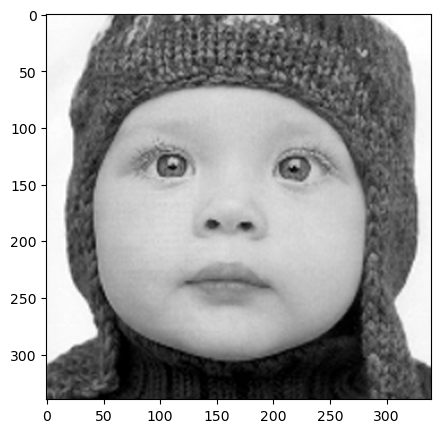

In [124]:
show_image(np.clip((img_mr_y*255.0),0,255).astype(np.uint8))

242


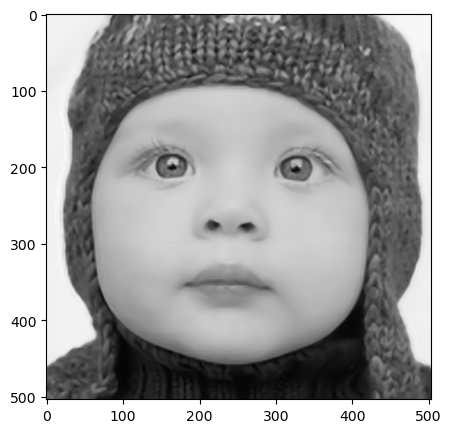

In [183]:
show_image(np.clip((img_sr_y[3:int(Hmr*1.5)-3,3:int(Wmr*1.5)-3]*255.0),0,255).astype(np.uint8))

In [210]:
img_sr_cr = cv2.resize(img_lr_cr,dsize=(Hsr,Wsr),interpolation=cv2.INTER_CUBIC)
img_sr_cb = cv2.resize(img_lr_cb,dsize=(Hsr,Wsr),interpolation=cv2.INTER_CUBIC)

#img_sr_cr = img_hr_cr
#img_sr_cb = img_hr_cb

img_sr_ycrcb = np.stack((img_sr_y,img_sr_cr,img_sr_cb),axis=2)

img_sr_bgr = cv2.cvtColor((img_sr_ycrcb*255.0).astype(np.uint8),cv2.COLOR_YCrCb2BGR)/255.0
img_sr_rgb = img_sr_bgr.copy()
img_sr_rgb[:,:,0] = img_sr_bgr[:,:,2]
img_sr_rgb[:,:,2] = img_sr_bgr[:,:,0]

img_og_bgr = cv2.imread(
    '/scratch_net/kringel/hchoong/github/quantum-cv/AplusCodes_SR/ResultsRGB-2022-11-13_11-56-07/baby_GT[1-Original].bmp') #reads as BGR
if np.max(img_og_bgr)>1:
    print(np.max(img_og_bgr))
    img_og_bgr = img_og_bgr/255.0

img_og_rgb = img_og_bgr.copy()
img_og_rgb[:,:,0] = img_og_bgr[:,:,2]
img_og_rgb[:,:,2] = img_og_bgr[:,:,0]

img_hr_rgb_adjusted = cv2.resize(img_hr_rgb,dsize=(510,510),interpolation=cv2.INTER_CUBIC)

psnr_rgb1 = calculate_psnr(img_hr_rgb*255.0,img_bicubic_rgb*255.0)
print("psnr_rgb = %f"%psnr_rgb1)

#psnr_rgb2 = calculate_psnr(img_hr_rgb*255.0,img_sr_rgb*255.0)
#print("psnr_rgb = %f"%psnr_rgb2)

psnr_rgb3 = calculate_psnr(
    img_hr_rgb[3:-5,3:-5]*255.0,img_sr_rgb[3:-3,3:-3]*255.0)
print("psnr_rgb = %f"%psnr_rgb3)

psnr_rgb4 = calculate_psnr(
    img_hr_rgb_adjusted[3:-3,3:-3]*255.0,img_sr_rgb[3:-3,3:-3]*255.0)
print("psnr_rgb = %f"%psnr_rgb4)

psnr_rgb5 = calculate_psnr(
    img_og_rgb*255.0,(img_sr_rgb[3:-3,3:-3]*255.0).astype(np.uint8))
print("psnr_rgb = %f"%psnr_rgb5)

psnr_rgb6 = calculate_psnr(
    img_hr_rgb[3:-5,3:-5]*255.0,img_sr_pred_rgb*255.0)
print("psnr_rgb = %f"%psnr_rgb6)

psnr_rgb7 = calculate_psnr(
    img_og_rgb*255.0,img_sr_pred_rgb*255.0)
print("psnr_rgb = %f"%psnr_rgb7)

psnr_rgb8 = calculate_psnr(
    img_hr_rgb_adjusted[3:-3,3:-3]*255.0,img_sr_pred_rgb*255.0)
print("psnr_rgb = %f"%psnr_rgb8)

psnr_y = calculate_psnr(
    img_hr_y[3:-5,3:-5]*255.0,(img_sr_y[3:-3,3:-3]*255.0).astype(np.uint8))
print("psnr_y = %f"%psnr_y)

255
psnr_rgb = 31.752281
psnr_rgb = 25.950703
psnr_rgb = 24.344904
psnr_rgb = 25.983607
psnr_rgb = 32.440410
psnr_rgb = 32.574250
psnr_rgb = 27.720855
psnr_y = 26.245661


In [205]:
img_sr_pred_rgb.shape

(504, 504, 3)

In [198]:
img_sr_y[100:111,100:111]

array([[0.3950722 , 0.38017403, 0.3390672 , 0.33377033, 0.36227983,
        0.42128547, 0.46459248, 0.45353791, 0.42242754, 0.37785049,
        0.32713803],
       [0.38167327, 0.37061305, 0.35001628, 0.35271629, 0.38965054,
        0.4529366 , 0.50122586, 0.48562092, 0.46077444, 0.43106515,
        0.38220544],
       [0.35622381, 0.34976276, 0.35137526, 0.36305746, 0.40387343,
        0.4646261 , 0.49792104, 0.48756122, 0.46062538, 0.45033076,
        0.4277161 ],
       [0.35727187, 0.35200571, 0.34002341, 0.35313694, 0.39833546,
        0.44244352, 0.4810814 , 0.48808836, 0.47164082, 0.45507416,
        0.4446935 ],
       [0.37564891, 0.36568171, 0.34693445, 0.36280259, 0.3841495 ,
        0.40961113, 0.43841031, 0.46029839, 0.45899811, 0.45645662,
        0.44969704],
       [0.42090028, 0.40873688, 0.3848618 , 0.37275272, 0.36582711,
        0.36441694, 0.392168  , 0.42079405, 0.45042909, 0.46347216,
        0.46532607],
       [0.44314998, 0.43402003, 0.40749847, 0.38187151, 0.

In [156]:
Hhr

512

In [149]:
int(Wmr*1.5)-3

507

In [201]:
img_og_bgr = cv2.imread(
    '/scratch_net/kringel/hchoong/github/quantum-cv/AplusCodes_SR/ResultsRGB-2022-11-13_11-56-07/baby_GT[1-Original].bmp') #reads as BGR
if np.max(img_og_bgr)>1:
    print(np.max(img_og_bgr))
    img_og_bgr = img_og_bgr/255.0

img_og_rgb = img_og_bgr.copy()
img_og_rgb[:,:,0] = img_og_bgr[:,:,2]
img_og_rgb[:,:,2] = img_og_bgr[:,:,0]

#img_sr_pred_bgr = cv2.imread(
#    '/scratch_net/kringel/hchoong/github/quantum-cv/AplusCodes_SR/ResultsRGB-2022-11-13_11-56-07/baby_GT[3-Yang et al.].bmp') #reads as BGR
img_sr_pred_bgr = cv2.imread(
    '/scratch_net/kringel/hchoong/github/quantum-cv/AplusCodes_SR/ResultsRGB-2022-11-13_11-56-07/baby_GT[2-Bicubic].bmp') #reads as BGR
if np.max(img_sr_pred_bgr)>1:
    print(np.max(img_sr_pred_bgr))
    img_sr_pred_bgr = img_sr_pred_bgr/255.0

img_sr_pred_rgb = img_sr_pred_bgr.copy()
img_sr_pred_rgb[:,:,0] = img_sr_pred_bgr[:,:,2]
img_sr_pred_rgb[:,:,2] = img_sr_pred_bgr[:,:,0]




255
255


In [ ]:
img_sr_pred_

In [144]:
#psnr_rgb3 = calculate_psnr(img_hr_rgb*255.0,img_sr_pred_rgb*255.0)
#print("psnr_rgb = %f"%psnr_rgb3)

psnr_rgb4 = calculate_psnr(img_sr_pred_rgb*255.0,img_og_rgb*255.0)
print("psnr_rgb = %f"%psnr_rgb4)

psnr_rgb = 32.574250


150


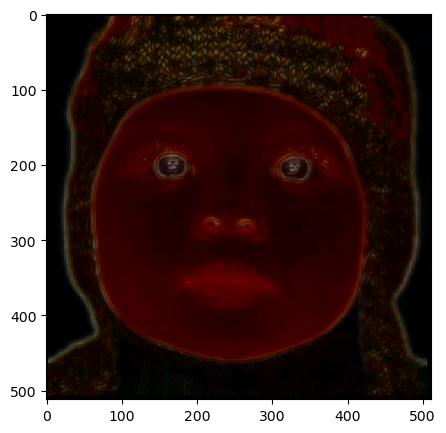

In [102]:
show_image(np.clip((img_sr_rgb*255.0),0,255).astype(np.uint8))

In [225]:
dict_hires

array([[ 0.05223505, -0.12770968, -0.1933552 , ...,  0.12745699,
         0.04226438, -0.14617477],
       [ 0.07189103, -0.2099625 ,  0.01036046, ...,  0.10947944,
         0.04717706, -0.0806738 ],
       [-0.00275953, -0.26887855,  0.15512036, ...,  0.10556214,
         0.05744318, -0.09321654],
       ...,
       [ 0.08390362, -0.03589195, -0.11291093, ..., -0.24791495,
        -0.03131009,  0.17120703],
       [ 0.06165184,  0.04089064, -0.00328551, ..., -0.21358827,
         0.01400979, -0.0811527 ],
       [-0.09844409,  0.04364978, -0.01352809, ..., -0.21203681,
        -0.04849196,  0.0781121 ]])

In [200]:
hgridx

array([  3,   6,   9,  12,  15,  18,  21,  24,  27,  30,  33,  36,  39,
        42,  45,  48,  51,  54,  57,  60,  63,  66,  69,  72,  75,  78,
        81,  84,  87,  90,  93,  96,  99, 102, 105, 108, 111, 114, 117,
       120, 123, 126, 129, 132, 135, 138, 141, 144, 147, 150, 153, 156,
       159, 162, 165, 168, 171, 174, 177, 180, 183, 186, 189, 192, 195,
       198, 201, 204, 207, 210, 213, 216, 219, 222, 225, 228, 231, 234,
       237, 240, 243, 246, 249, 252, 255, 258, 261, 264, 267, 270, 273,
       276, 279, 282, 285, 288, 291, 294, 297, 300, 303, 306, 309, 312,
       315, 318, 321, 324, 327, 330, 333, 336, 339, 342, 345, 348, 351,
       354, 357, 360, 363, 366, 369, 372, 375, 378, 381, 384, 387, 390,
       393, 396, 399, 402, 405, 408, 411, 414, 417, 420, 423, 426, 429,
       432, 435, 438, 441, 444, 447, 450, 453, 456, 459, 462, 465, 468,
       471, 474, 477, 480, 483, 486, 489, 492, 495, 498, 498])

In [195]:
c = H_pred[0]

In [196]:
c

array([ 5.30600141e-03,  2.32763334e-03,  3.16359810e-04,  2.99336115e-03,
        1.98853140e-03, -3.27881908e-03, -2.13176069e-03, -8.14864295e-04,
       -2.99020894e-04,  9.19672396e-03,  5.73674237e-03, -7.19961436e-03,
       -7.16961338e-03, -3.88709256e-03, -1.91755671e-03,  5.07833893e-04,
       -1.42905343e-04,  6.24841686e-04,  5.62889101e-03,  2.42555102e-03,
       -8.90660787e-03, -6.33999671e-03,  1.22102375e-03, -3.40359116e-04,
       -1.16171205e-03, -1.82679229e-03, -1.65178700e-03,  4.23143745e-04,
        7.37168125e-04, -3.24189397e-03, -6.57939450e-03, -8.31555011e-04,
       -4.70462046e-04, -1.84351272e-03, -9.50421374e-04,  3.09161382e-05,
       -4.08432307e-04, -1.03176227e-04, -5.28279176e-04, -6.91074302e-03,
       -2.92721491e-03, -1.69957901e-03, -1.58385069e-03, -3.03150265e-03,
       -8.86970195e-04, -6.31907543e-04,  2.04820246e-04,  1.30719666e-03,
       -3.09588177e-03, -2.85749361e-03,  4.37843161e-04, -1.06369839e-03,
       -2.83625056e-03, -

In [197]:
c.reshape((9,9),order='F')

array([[ 5.30600141e-03,  9.19672396e-03,  5.62889101e-03,
         4.23143745e-04, -4.08432307e-04, -6.31907543e-04,
        -1.45351499e-03, -7.24785622e-04, -9.29844786e-04],
       [ 2.32763334e-03,  5.73674237e-03,  2.42555102e-03,
         7.37168125e-04, -1.03176227e-04,  2.04820246e-04,
         4.55084555e-04,  1.42005019e-03,  1.65528161e-03],
       [ 3.16359810e-04, -7.19961436e-03, -8.90660787e-03,
        -3.24189397e-03, -5.28279176e-04,  1.30719666e-03,
         4.37804226e-03,  8.83987451e-03,  6.98356719e-03],
       [ 2.99336115e-03, -7.16961338e-03, -6.33999671e-03,
        -6.57939450e-03, -6.91074302e-03, -3.09588177e-03,
         6.88622970e-03,  1.46065610e-02,  1.25024343e-02],
       [ 1.98853140e-03, -3.88709256e-03,  1.22102375e-03,
        -8.31555011e-04, -2.92721491e-03, -2.85749361e-03,
         1.83667784e-03,  9.53515872e-03,  1.15092337e-02],
       [-3.27881908e-03, -1.91755671e-03, -3.40359116e-04,
        -4.70462046e-04, -1.69957901e-03,  4.378431

In [146]:
(SS_res/SS_tot).shape

(167,)

In [140]:
res_diff_sq.shape

(167, 144)

In [115]:
sc_timer

11.542826652526855

In [82]:
step = patch_size*2-overlap*2

startx = 2
starty = 2
endx = startx+step*(int((Wmr-4-patch_size*2)/step)+1)
endy = starty+step*(int((Hmr-4-patch_size*2)/step)+1)

#mgridx = np.arange(2,Wmr-2-overlap*2,step)
#mgridy = np.arange(2,Hmr-2-overlap*2,step)

mgridx = np.arange(startx,endx,step)
mgridy = np.arange(starty,endy,step)

mgridx = np.append(mgridx,Wmr-2-patch_size*2)
mgridy = np.append(mgridy,Hmr-2-patch_size*2)

for i in range(len(mgridy)):
    for j in range(len(mgridx)):
        y = img_lr_feat[mgridy[i]:mgridy[i]+patch_size*2,mgridx[j]:mgridx[j]+patch_size*2].flatten('F')
        y_norm = np.sqrt(np.sum(np.dot(y,y)))
        if y_norm>1:
            y/=y_norm

        D = dict_lores.shape[1]
        lasso = Lasso(alpha=1e-5, fit_intercept=False, random_state=0, max_iter=100,tol=1e-4)
        lasso.fit(dict_lores,y)
        w = lasso.coef_
        r2 = lasso.score(dict_lores,y)
        zero_norm = np.matmul(np.where(np.abs(w)>0,1,0),np.ones(D))
        #print(r2)
        print(zero_norm)
    print(i)
        


28.0
38.0
35.0
37.0
33.0
29.0
26.0
26.0
23.0
38.0
28.0
25.0
22.0
23.0
28.0
27.0
43.0
36.0
48.0
47.0
34.0
43.0
59.0
76.0
113.0
146.0
147.0
162.0
123.0
153.0
138.0
109.0
85.0
100.0
121.0
117.0
127.0
117.0
131.0
152.0
147.0
149.0
157.0
137.0
126.0
159.0
152.0
148.0
139.0
130.0
115.0
119.0
127.0
140.0
152.0
140.0
130.0
115.0
159.0
146.0
161.0
137.0
135.0
132.0
144.0
156.0
143.0
114.0
116.0
135.0
129.0
113.0
141.0
126.0
122.0
137.0
148.0
163.0
134.0
155.0
138.0
174.0
139.0
132.0
147.0
145.0
128.0
151.0
125.0
142.0
162.0
126.0
151.0
152.0
103.0
135.0
138.0
152.0
122.0
131.0
150.0
138.0
141.0
143.0
139.0
139.0
148.0
122.0
170.0
147.0
138.0
159.0
131.0
127.0
102.0
119.0
103.0
127.0
140.0
139.0
114.0
99.0
94.0
86.0
80.0
98.0
111.0
117.0
136.0
126.0
116.0
132.0
118.0
118.0
122.0
120.0
154.0
152.0
144.0
153.0
129.0
168.0
145.0
139.0
126.0
161.0
103.0
99.0
69.0
54.0
37.0
32.0
26.0
24.0
21.0
19.0
14.0
23.0
19.0
22.0
24.0
20.0
25.0
27.0
30.0
23.0
23.0
0
23.0
31.0
31.0
32.0
37.0
30.0
25.0
17.0
18.0
2

KeyboardInterrupt: 

In [61]:
mgridx

array([  2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,  26,
        28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,  52,
        54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,  78,
        80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102, 104,
       106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130,
       132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156,
       158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182,
       184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208,
       210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234,
       236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260,
       262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286,
       288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312,
       314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 332])

In [36]:
mgridx

array([  2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,  26,
        28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,  52,
        54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,  78,
        80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102, 104,
       106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130,
       132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156,
       158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182,
       184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208,
       210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234,
       236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260,
       262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286,
       288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312,
       314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 332])

In [31]:
mgridx.shape

(166,)

In [27]:
img_lr_G21

array([[-9.87442796e-01, -9.88764958e-01, -2.13448038e-03, ...,
        -2.26962524e-03, -9.92684915e-01, -9.91378600e-01],
       [-9.90472023e-01, -9.90899652e-01, -5.70937341e-04, ...,
        -1.47801857e-03, -9.94845407e-01, -9.93968135e-01],
       [-9.95610950e-01, -9.94530940e-01,  2.06768325e-03, ...,
        -1.79478226e-04, -9.98405623e-01, -9.98233249e-01],
       ...,
       [-3.72357513e-01, -3.59948792e-01,  1.19601803e-02, ...,
         5.68298786e-02, -3.11635689e-01, -3.39984910e-01],
       [-2.73083290e-01, -2.91901137e-01, -5.60256686e-02, ...,
         5.38363186e-02, -2.99177425e-01, -3.25991828e-01],
       [-2.11483953e-01, -2.49607082e-01, -9.80931217e-02, ...,
         5.21548136e-02, -2.91474506e-01, -3.17410061e-01]])

In [26]:
img_lr_feat.shape

(340, 340, 4)

In [25]:
print(img_mr_y.shape)

(340, 340)


In [10]:
#y = img_lr_feat[1:7,1:7].flatten('F')
#y = img_lr_feat[101:107,101:107].flatten('F')
y = img_lr_feat[201:207,201:207].flatten('F')
y_norm = np.sqrt(np.sum(np.dot(y,y)))
if y_norm>1:
    y/=y_norm

In [19]:
D = dict_lores.shape[1]
lasso = Lasso(alpha=1e-5, fit_intercept=False, random_state=0, max_iter=1000)
lasso.fit(dict_lores,y)
w = lasso.coef_
zero_norm = np.matmul(np.where(np.abs(w)>0,1,0),np.ones(D))
print(zero_norm)

49.0


In [20]:
lasso.intercept_

0.0

In [21]:
y_pred = np.matmul(dict_lores,w)

In [22]:
y

array([-1.35612558e-03, -2.92399955e-03, -8.11798028e-03, -1.42538510e-02,
       -1.06023883e-02,  1.23317107e-03,  7.45355066e-03,  1.21985378e-03,
       -5.20906350e-03, -8.57357483e-03, -7.56325027e-03, -2.46181375e-03,
        2.01489910e-02,  1.11061575e-02,  6.51466463e-03,  8.71796586e-03,
        9.45123241e-04, -1.26098128e-02,  1.42727552e-02,  1.06342649e-02,
        9.45512075e-03,  1.12623643e-02,  4.26539149e-03, -7.91964649e-03,
       -7.10382404e-03,  3.57946077e-04,  2.34913745e-03, -2.34640310e-03,
        4.10975325e-04,  9.00109675e-03, -1.79434647e-02, -1.13385055e-02,
       -6.60921754e-03, -6.47075222e-03,  3.03444307e-03,  1.67075592e-02,
        5.29799167e-04,  7.22213881e-03, -8.87637513e-05, -3.79396320e-03,
       -2.31317520e-03, -2.63018500e-03, -3.78743039e-03,  2.10719452e-03,
       -6.32090321e-03, -3.82857848e-03,  8.11499156e-03,  6.08405566e-03,
       -5.87919614e-03, -5.44047536e-03, -9.88219236e-03, -6.14814998e-03,
        3.79858588e-03,  

In [23]:
y_pred

array([-2.28459293e-04, -7.43365030e-03, -1.10618926e-02, -1.71427016e-02,
       -8.77805410e-03,  4.74693441e-03,  1.32846513e-02,  4.71345092e-03,
       -2.36721412e-03, -7.63968450e-03, -6.86993637e-03, -2.86752412e-03,
        1.69291220e-02,  1.09763829e-02,  5.95512062e-03,  5.03652148e-03,
       -5.22770574e-04, -1.06785135e-02,  9.57411049e-03,  1.02757515e-02,
        8.07984500e-03,  9.62141155e-03,  1.84785158e-03, -7.64742492e-03,
       -5.59318942e-03,  4.67607236e-03,  1.48011306e-03,  1.73055095e-03,
        5.57915382e-03,  5.21229387e-03, -1.99281981e-02, -1.18082470e-02,
       -7.19287379e-03, -7.13347871e-03,  4.50346646e-03,  1.54278135e-02,
        9.40441330e-04,  5.31764207e-03, -2.25180748e-04, -2.09305800e-03,
       -2.27362954e-03,  1.67016442e-03, -1.09219761e-03, -1.15601085e-03,
       -4.01377481e-03, -4.72226888e-03,  5.28554963e-03,  6.41039467e-03,
       -3.10378213e-03, -5.99580686e-03, -7.50765092e-03, -6.77749093e-03,
        1.24278673e-03, -

In [24]:
D = dict_lores.shape[1]
X_train = dict_lores
y_train = y

alphas = np.logspace(-7, 1, 20)
for i in range(len(alphas)):
    lasso = Lasso(alpha=alphas[i],random_state=0, max_iter=10000)
    lasso.fit(X_train, y_train)
    y_train_pred = np.matmul(X_train,lasso.coef_)
    #y_val_pred = np.matmul(X_val,lasso.coef_)
    r2_train = lasso.score(X_train,y_train)
    #r2_val = lasso.score(X_val,y_val)
    sqloss_train = np.dot(y_train_pred-y_train,y_train_pred-y_train)
    #sqloss_val = np.dot(y_val_pred-y_val,y_val_pred-y_val)

    one_norm = np.matmul(np.abs(lasso.coef_),np.ones(D))
    zero_norm = np.matmul(np.where(np.abs(lasso.coef_)>0,1,0),np.ones(D))

    #scores.append(r2_val)
    #scores_train_tmp.append(r2_train)
    #scores_val_tmp.append(r2_val)
    #scores_train.append(sqloss_train)
    #scores_val.append(sqloss_val)

    #scores_train_arr[j][i] = r2_train
    #scores_val_arr[j][i] = r2_val

    print(i)
    print("alpha=%f"%alphas[i])
    #print(lasso.coef_)
    print("r2=%f"%r2_train)
    print("sqloss=%f"%sqloss_train)
    print(one_norm)
    print(zero_norm)
    #print(y_val_pred)
    print("\n")


/scratch_net/kringel/hchoong/conda_envs/quantum_cv2/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.019e-05, tolerance: 1.736e-06
  model = cd_fast.enet_coordinate_descent(


0
alpha=0.000000
r2=0.999787
sqloss=0.001648
3.1544900654473085
166.0




/scratch_net/kringel/hchoong/conda_envs/quantum_cv2/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.131e-05, tolerance: 1.736e-06
  model = cd_fast.enet_coordinate_descent(


1
alpha=0.000000
r2=0.999182
sqloss=0.000524
2.8424284415241416
119.0




/scratch_net/kringel/hchoong/conda_envs/quantum_cv2/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.628e-06, tolerance: 1.736e-06
  model = cd_fast.enet_coordinate_descent(


2
alpha=0.000001
r2=0.996574
sqloss=0.000061
2.491950614524293
101.0


3
alpha=0.000002
r2=0.986473
sqloss=0.000301
1.9821539727501436
83.0


4
alpha=0.000005
r2=0.944528
sqloss=0.001255
1.1816585845961307
62.0


5
alpha=0.000013
r2=0.868492
sqloss=0.002867
0.5957624512933828
47.0


6
alpha=0.000034
r2=0.767710
sqloss=0.004134
0.3097438800664721
36.0


7
alpha=0.000089
r2=0.624229
sqloss=0.006567
0.14654480126952224
17.0


8
alpha=0.000234
r2=0.433787
sqloss=0.010123
0.06577256778635034
4.0


9
alpha=0.000616
r2=0.000000
sqloss=0.017580
0.0
0.0


10
alpha=0.001624
r2=0.000000
sqloss=0.017580
0.0
0.0


11
alpha=0.004281
r2=0.000000
sqloss=0.017580
0.0
0.0


12
alpha=0.011288
r2=0.000000
sqloss=0.017580
0.0
0.0


13
alpha=0.029764
r2=0.000000
sqloss=0.017580
0.0
0.0


14
alpha=0.078476
r2=0.000000
sqloss=0.017580
0.0
0.0


15
alpha=0.206914
r2=0.000000
sqloss=0.017580
0.0
0.0


16
alpha=0.545559
r2=0.000000
sqloss=0.017580
0.0
0.0


17
alpha=1.438450
r2=0.000000
sqloss=0.017580
0.0
0.0



In [59]:
yima_dict = scipy.io.loadmat('CVPR08-SR/Data/Dictionary/Dictionary4.mat')

In [62]:
yima_dict['Dl'].shape

(144, 1024)

In [ ]:
import numpy as np
from sklearn.decomposition import SparseCoder
X = np.array([[-1, -1, -1], [0, 0, 3]]) #Y
dictionary = np.array(
    [[0, 1, 0],
     [-1, -1, 2],
     [1, 1, 1],
     [0, 1, 1],
     [0, 2, 1]],
   dtype=np.float64
)
coder = SparseCoder(
    dictionary=dictionary, transform_algorithm='lasso_lars',
    transform_alpha=1e-10,
)
coder.transform(X) #w

A = np.eye(10)
B = np.eye(10)
A[0][1] = 2
B[1][0] = 2